In [1]:
import os
import os.path as osp
import sys
sys.path.insert(0, osp.dirname(osp.abspath(".")))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.datasets import MNIST
from model.mnist import VAEMNIST, CVAEMNIST

%load_ext autoreload
%autoreload 2

# Load MNIST Dataet

In [3]:
transform = T.Compose([T.ToTensor()])
rev_transform = T.Compose([T.ToPILImage()])

# Load dataset
dataset = MNIST(root="../download", train=False, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

## Select candidate digits and labels

In [4]:
N_SAMPLES = 10
N_CLASSES = 10

In [5]:
candidates = {}

all_labels = np.concatenate([ labels.cpu().numpy() for _, labels in dataloader ])
for label in range(N_CLASSES):
    indices = np.where(all_labels == label)[0]
    np.random.shuffle(indices)
    indices = indices[:N_SAMPLES].tolist()
    candidates[label] = indices

## Show candidate data

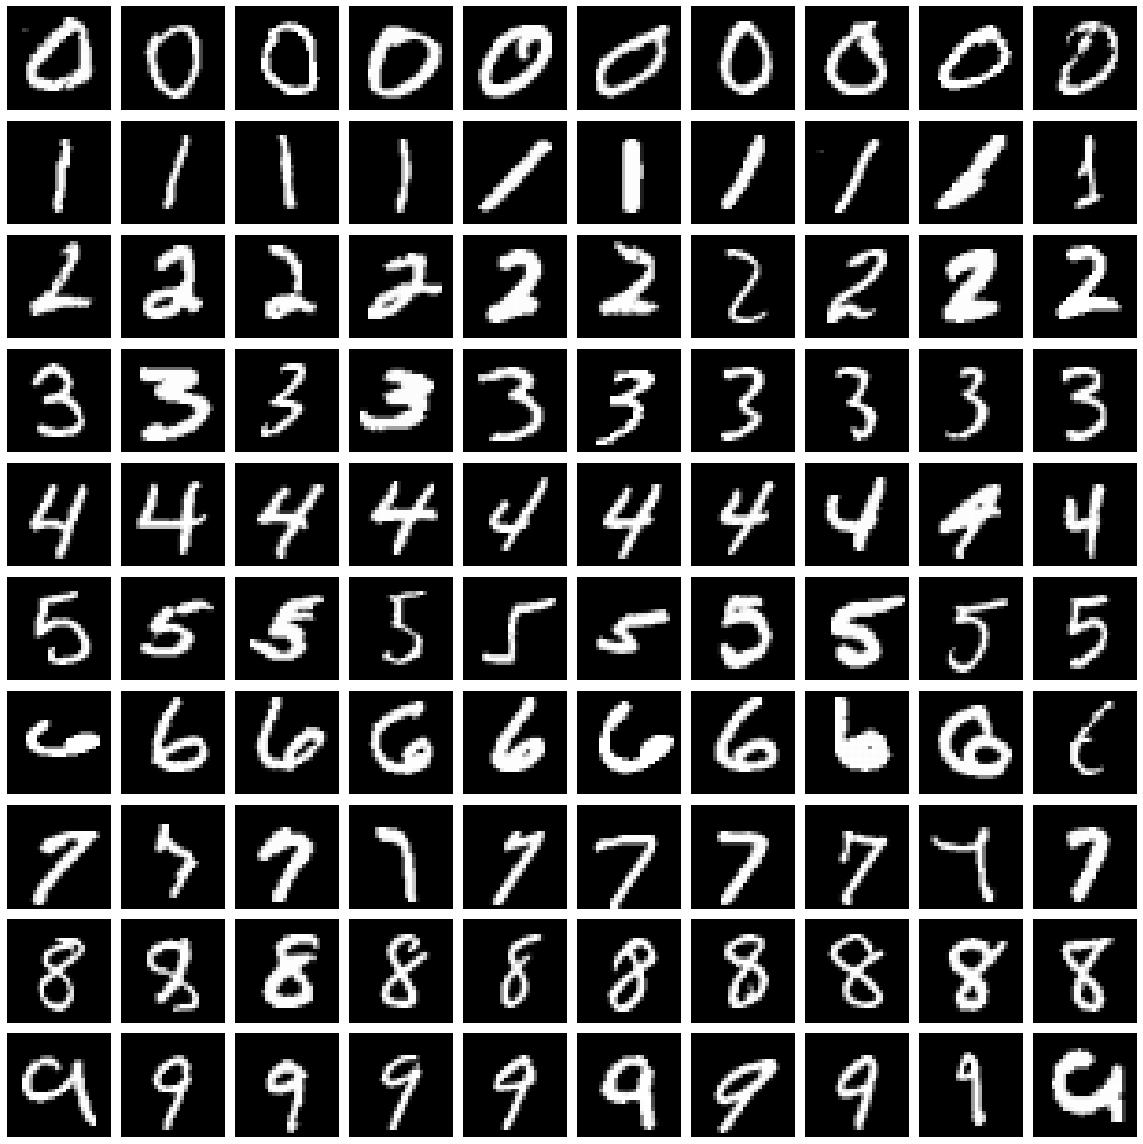

In [6]:
fig, axes = plt.subplots(nrows=N_CLASSES, ncols=N_SAMPLES, figsize=(16, 16))

for i in range(N_CLASSES):
    for j in range(N_SAMPLES):
        idx = candidates[i][j]
        img, label = dataset[idx]
        axes[i][j].imshow(np.array(rev_transform(img)), cmap='gray')
        axes[i][j].set_axis_off()
        
plt.tight_layout()

# Evaluate CVAE on mnist

In [7]:
DEVICE = "cuda"
CHECKPOINT_PATH = "../run/mnist_cvae_checkpoint/best.pth"

In [8]:
checkpoint = torch.load(CHECKPOINT_PATH)

## Load pretrained model

In [9]:
model = CVAEMNIST(latent_dim=32)
model.load_state_dict(checkpoint['model'])
model = model.to(DEVICE)
model = model.eval()

## Get latent feature of candidate data

In [10]:
all_latents = []
all_labels = []

for imgs, labels in dataloader:
    imgs = imgs.to(DEVICE)
    labels = labels.to(DEVICE)
    
    latents = model.get_latent(imgs, labels)
    all_latents.append(latents.detach().cpu().numpy())
    all_labels.append(labels.detach().cpu().numpy())
    
all_latents = np.concatenate(all_latents)
all_labels = np.concatenate(all_labels)

if all_latents.shape[-1] != 2:
    pca = PCA(n_components=2)
    pca.fit(all_latents)
    all_reduced = pca.transform(all_latents)

## Visualize latent features

In [11]:
reduced_group = {}

for label in np.unique(all_labels):
    indices = np.where(all_labels == label)
    reduced = all_reduced[indices]
    reduced_group[label] = reduced

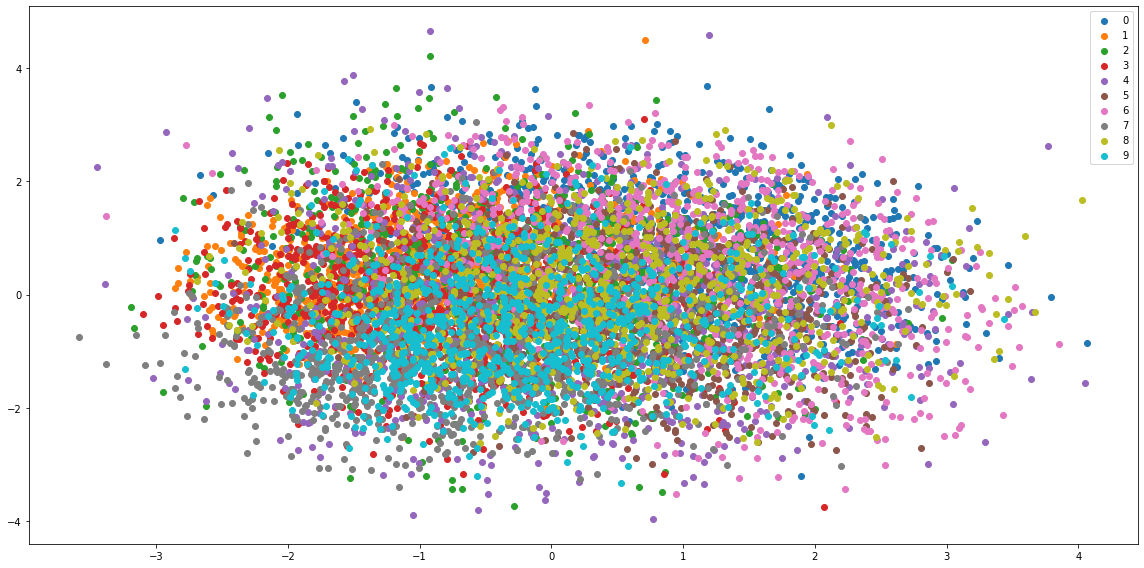

In [12]:
plt.figure(figsize=(16, 8))

for label, latents in reduced_group.items():
    plt.scatter(latents[:, 0], latents[:, 1], label=str(label))
    
plt.legend()
plt.tight_layout()

## Visualize Reconstruction image

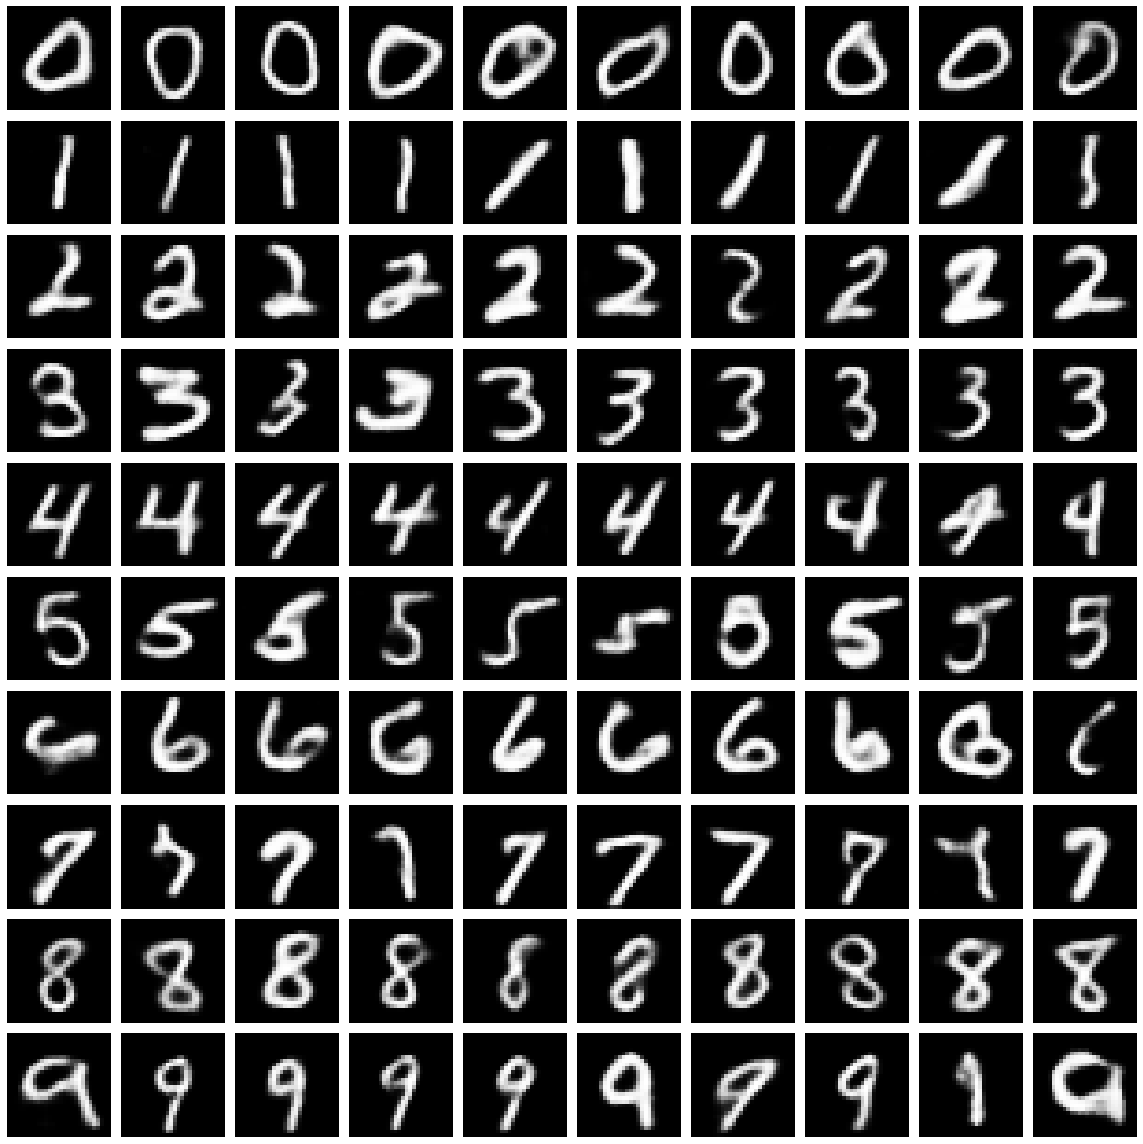

In [13]:
fig, axes = plt.subplots(nrows=N_CLASSES, ncols=N_SAMPLES, figsize=(16, 16))

for i in range(N_CLASSES):
    for j in range(N_SAMPLES):
        idx = candidates[i][j]
        img, label = dataset[idx]
        img = img.unsqueeze(0).to(DEVICE)
        label = torch.LongTensor([label]).to(DEVICE)
        rec, _, _ = model(img, label)
        rec = rec[0].detach().cpu()
        axes[i][j].imshow(np.array(rev_transform(rec)), cmap='gray')
        axes[i][j].set_axis_off()
        
plt.tight_layout()

## Generate images with z and label

In [14]:
N_CLASSES = CVAEMNIST.N_CLASSES

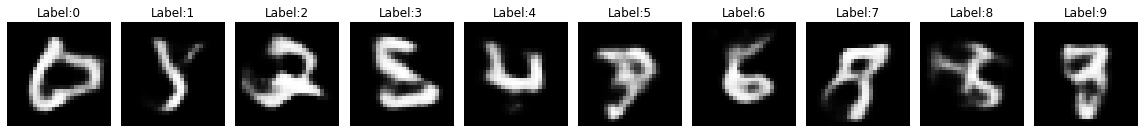

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=N_CLASSES, figsize=(16, 4))

for i in range(N_CLASSES):
    z = torch.randn(1, 32).to(DEVICE)
    label = torch.LongTensor([i]).to(DEVICE)
    
    img = model.generate(z, label)[0].detach().cpu()
    img = np.array(rev_transform(img))
    axes[i].imshow(img, cmap='gray')
    axes[i].set_axis_off()
    axes[i].set_title("Label:{}".format(i))
    
plt.tight_layout()